In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import adjusted_rand_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')
# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")


In [ ]:
# Replace this path with your actual file path in Colab
mcdonalds = pd.read_csv('/content/sample_data/mcdonalds.csv')

**STEP 4: Exploring Data**

---



=== Step 4: Exploring Data ===
Dataset shape: (1453, 15)
Column names: ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age', 'VisitFrequency', 'Gender']

First 3 rows:
  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  

Mean values for binary variables:
yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy     

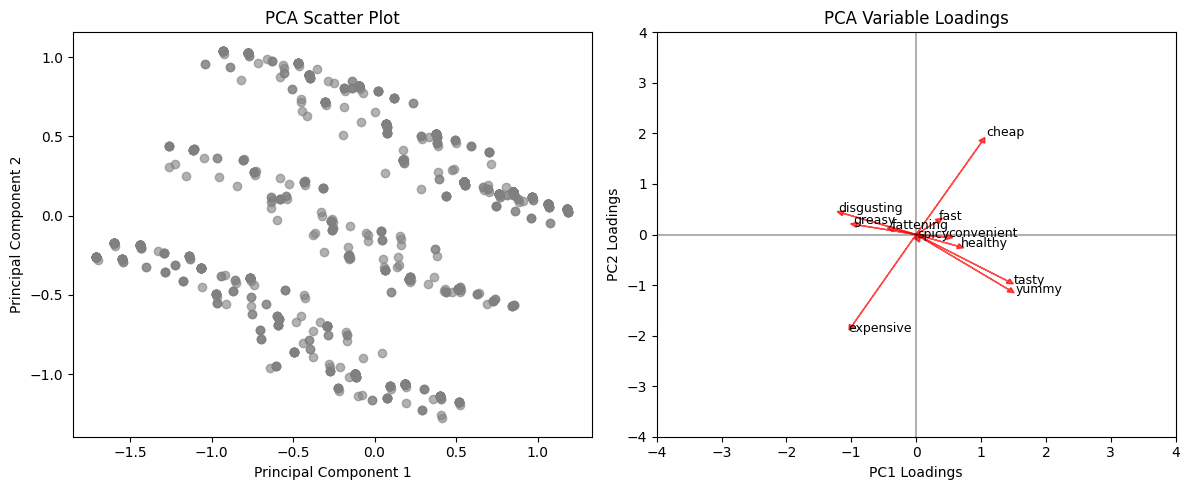

In [ ]:
print("=== Step 4: Exploring Data ===")
print(f"Dataset shape: {mcdonalds.shape}")
print(f"Column names: {list(mcdonalds.columns)}")
print("\nFirst 3 rows:")
print(mcdonalds.head(3))

# Convert binary columns to numeric (Yes=1, No=0)
binary_cols = ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast',
               'cheap', 'tasty', 'expensive', 'healthy', 'disgusting']

MD_x = mcdonalds[binary_cols].copy()
for col in binary_cols:
    MD_x[col] = (MD_x[col] == 'Yes').astype(int)

print("\nMean values for binary variables:")
print(MD_x.mean().round(2))

# PCA Analysis
print("\n=== PCA Analysis ===")
pca = PCA()
MD_pca = pca.fit_transform(MD_x)

print("PCA Summary:")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.round(3)}")
print(f"Cumulative explained variance: {pca.explained_variance_ratio_.cumsum().round(3)}")

# Plot PCA
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(MD_pca[:, 0], MD_pca[:, 1], alpha=0.6, color='grey')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')

# Show variable loadings
plt.subplot(1, 2, 2)
loadings = pca.components_[:2].T
for i, (var, loading) in enumerate(zip(binary_cols, loadings)):
    plt.arrow(0, 0, loading[0]*3, loading[1]*3, head_width=0.1, head_length=0.1,
              fc='red', ec='red', alpha=0.7)
    plt.text(loading[0]*3.2, loading[1]*3.2, var, fontsize=9)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel('PC1 Loadings')
plt.ylabel('PC2 Loadings')
plt.title('PCA Variable Loadings')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()


**STEP 5.1: K-Means Clustering**

---




=== Step 5.1: K-Means Clustering ===


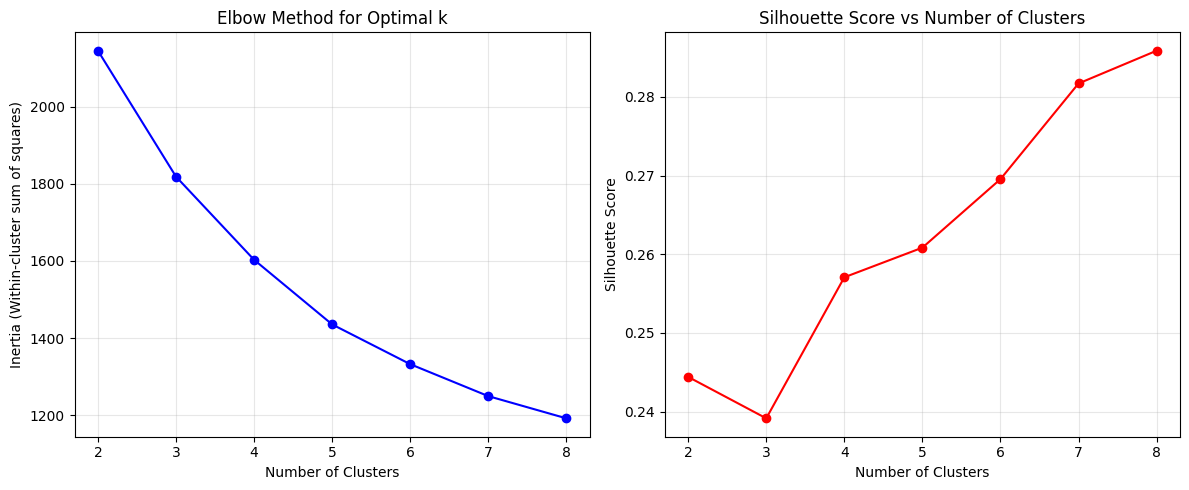

Selected k=4 clusters
Silhouette score for k=4: 0.257


In [ ]:
print("\n=== Step 5.1: K-Means Clustering ===")

# Function to evaluate different numbers of clusters
def evaluate_kmeans(data, k_range, n_init=10):
    """Evaluate k-means for different numbers of clusters"""
    results = {}
    inertias = []
    silhouette_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=1234, n_init=n_init)
        clusters = kmeans.fit_predict(data)

        inertias.append(kmeans.inertia_)
        if k > 1:
            sil_score = silhouette_score(data, clusters)
            silhouette_scores.append(sil_score)
        else:
            silhouette_scores.append(0)

        results[k] = {
            'model': kmeans,
            'clusters': clusters,
            'inertia': kmeans.inertia_,
            'silhouette': silhouette_scores[-1] if k > 1 else 0
        }

    return results, inertias, silhouette_scores

# Evaluate k-means for k=2 to 8
k_range = range(2, 9)
km_results, inertias, sil_scores = evaluate_kmeans(MD_x, k_range)

# Plot elbow curve and silhouette scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_range, sil_scores, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Select k=4 based on analysis
MD_k4 = km_results[4]['model']
k4_clusters = km_results[4]['clusters']

print(f"Selected k=4 clusters")
print(f"Silhouette score for k=4: {km_results[4]['silhouette']:.3f}")

**STEP 5.2: Gaussian Mixture Models**

---



=== Step 5.2: Gaussian Mixture Models ===


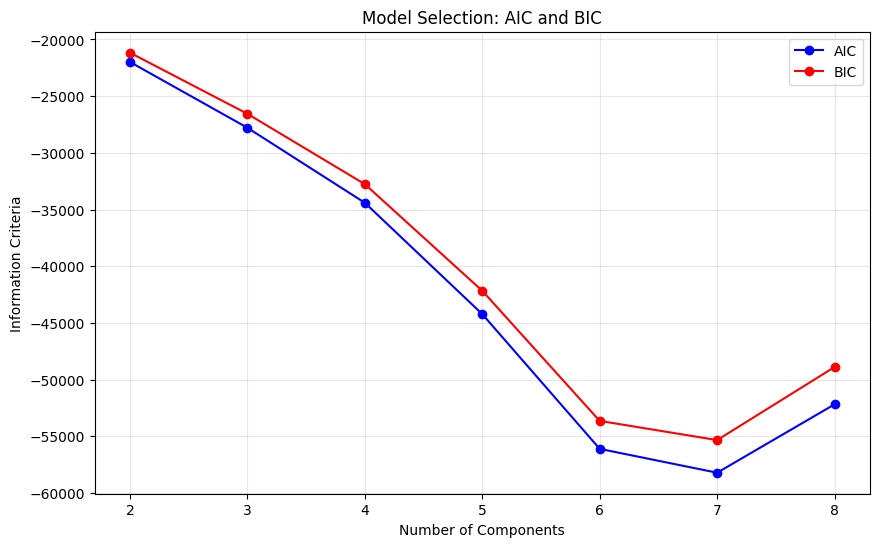


Contingency table: K-means vs GMM (k=4)
GMM        0    1    2    3
K-means                    
0         31   51  268   14
1          4  214    0   22
2        143    0  362   28
3          0    3    0  313

Adjusted Rand Index between K-means and GMM: 0.454

=== Step 5.3: Regression-based Segmentation ===
Like variable distribution:
Like
+1              152
+2              187
+3              229
+4              160
-1               58
-2               59
-3               73
-4               71
0               169
I hate it!-5    152
I love it!+5    143
Name: count, dtype: int64

Like_n variable distribution:
Like_n
1     152
2      71
3      73
4      59
5      58
6     169
7     152
8     187
9     229
10    160
11    143
Name: count, dtype: int64

Regression R-squared: 0.623


In [ ]:
print("\n=== Step 5.2: Gaussian Mixture Models ===")

# Evaluate Gaussian Mixture Models
def evaluate_gmm(data, k_range, n_init=10):
    """Evaluate GMM for different numbers of components"""
    results = {}
    aic_scores = []
    bic_scores = []

    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=1234, n_init=n_init)
        gmm.fit(data)
        clusters = gmm.predict(data)

        aic_scores.append(gmm.aic(data))
        bic_scores.append(gmm.bic(data))

        results[k] = {
            'model': gmm,
            'clusters': clusters,
            'aic': gmm.aic(data),
            'bic': gmm.bic(data),
            'log_likelihood': gmm.score(data)
        }

    return results, aic_scores, bic_scores

gmm_results, aic_scores, bic_scores = evaluate_gmm(MD_x, k_range)

# Plot information criteria
plt.figure(figsize=(10, 6))
plt.plot(k_range, aic_scores, 'b-o', label='AIC')
plt.plot(k_range, bic_scores, 'r-o', label='BIC')
plt.xlabel('Number of Components')
plt.ylabel('Information Criteria')
plt.title('Model Selection: AIC and BIC')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Compare k-means and GMM clustering for k=4
gmm_k4_clusters = gmm_results[4]['clusters']

# Create contingency table
contingency_table = pd.crosstab(k4_clusters, gmm_k4_clusters,
                               rownames=['K-means'], colnames=['GMM'])
print("\nContingency table: K-means vs GMM (k=4)")
print(contingency_table)

# Calculate adjusted rand index
ari = adjusted_rand_score(k4_clusters, gmm_k4_clusters)
print(f"\nAdjusted Rand Index between K-means and GMM: {ari:.3f}")

print("\n=== Step 5.3: Regression-based Segmentation ===")

# Convert Like variable to numeric (reverse scale)
like_mapping = {'I hate it!-5': 1, '-4': 2, '-3': 3, '-2': 4, '-1': 5,
                '0': 6, '+1': 7, '+2': 8, '+3': 9, '+4': 10, 'I love it!+5': 11}
mcdonalds['Like_n'] = mcdonalds['Like'].map(like_mapping)

print("Like variable distribution:")
print(mcdonalds['Like'].value_counts().sort_index())
print("\nLike_n variable distribution:")
print(mcdonalds['Like_n'].value_counts().sort_index())

# Prepare features for regression
X_reg = MD_x.copy()
y_reg = mcdonalds['Like_n']

# Simple regression-based segmentation using residuals
reg_model = LinearRegression()
reg_model.fit(X_reg, y_reg)
predictions = reg_model.predict(X_reg)
residuals = y_reg - predictions

print(f"\nRegression R-squared: {reg_model.score(X_reg, y_reg):.3f}")

**STEP 6: Profiling Segments**

---



=== Step 6: Profiling Segments ===


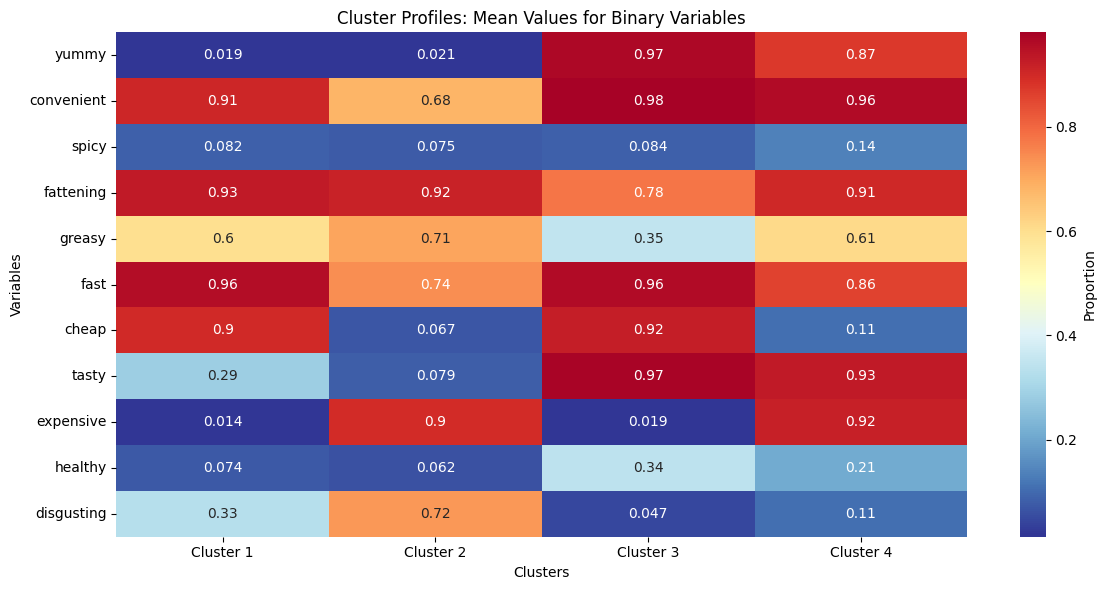

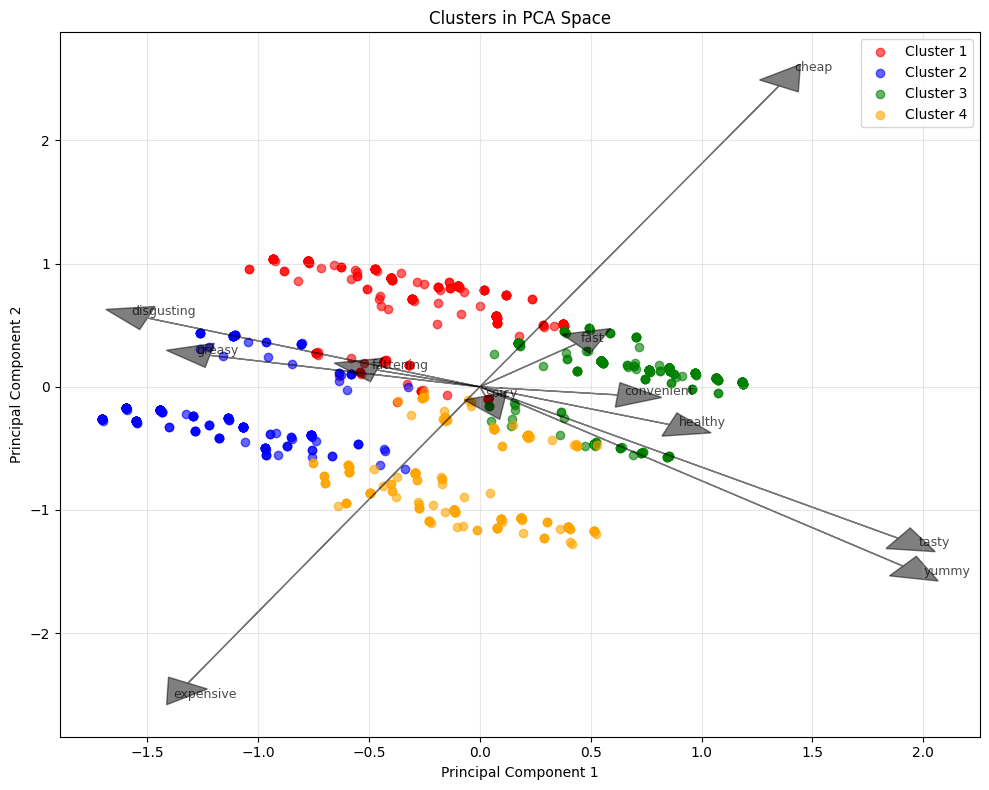

In [ ]:
print("\n=== Step 6: Profiling Segments ===")

# Create cluster profiles
cluster_profiles = []
for i in range(4):
    cluster_mask = k4_clusters == i
    profile = MD_x[cluster_mask].mean()
    cluster_profiles.append(profile)

profiles_df = pd.DataFrame(cluster_profiles, index=[f'Cluster {i+1}' for i in range(4)])

# Plot cluster profiles as heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(profiles_df.T, annot=True, cmap='RdYlBu_r', center=0.5,
            cbar_kws={'label': 'Proportion'})
plt.title('Cluster Profiles: Mean Values for Binary Variables')
plt.ylabel('Variables')
plt.xlabel('Clusters')
plt.tight_layout()
plt.show()

# Plot clusters in PCA space
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'orange']
for i in range(4):
    cluster_mask = k4_clusters == i
    plt.scatter(MD_pca[cluster_mask, 0], MD_pca[cluster_mask, 1],
                c=colors[i], label=f'Cluster {i+1}', alpha=0.6)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters in PCA Space')
plt.legend()
plt.grid(True, alpha=0.3)

# Add variable loadings
loadings = pca.components_[:2].T
for i, (var, loading) in enumerate(zip(binary_cols, loadings)):
    plt.arrow(0, 0, loading[0]*4, loading[1]*4, head_width=0.2, head_length=0.2,
              fc='black', ec='black', alpha=0.5)
    plt.text(loading[0]*4.2, loading[1]*4.2, var, fontsize=9, alpha=0.7)

plt.tight_layout()
plt.show()

**STEP 7: Describing Segments**

---




=== Step 7: Describing Segments ===
Contingency table: Cluster vs Like
Like     +1  +2   +3   +4  -1  -2  -3  -4   0  I hate it!-5  I love it!+5
Cluster                                                                  
1        46  44   17    3  30  29  35  38  66            56             0
2        14   6    8    0  12  18  30  27  36            89             0
3        51  79  138  110  10   6   1   3  34             2            99
4        41  58   66   47   6   6   7   3  33             5            44

Chi-square test: χ² = 828.358, p-value = 0.000

Contingency table: Cluster vs Gender
Gender   Female  Male
Cluster              
1           213   151
2           101   139
3           324   209
4           150   166


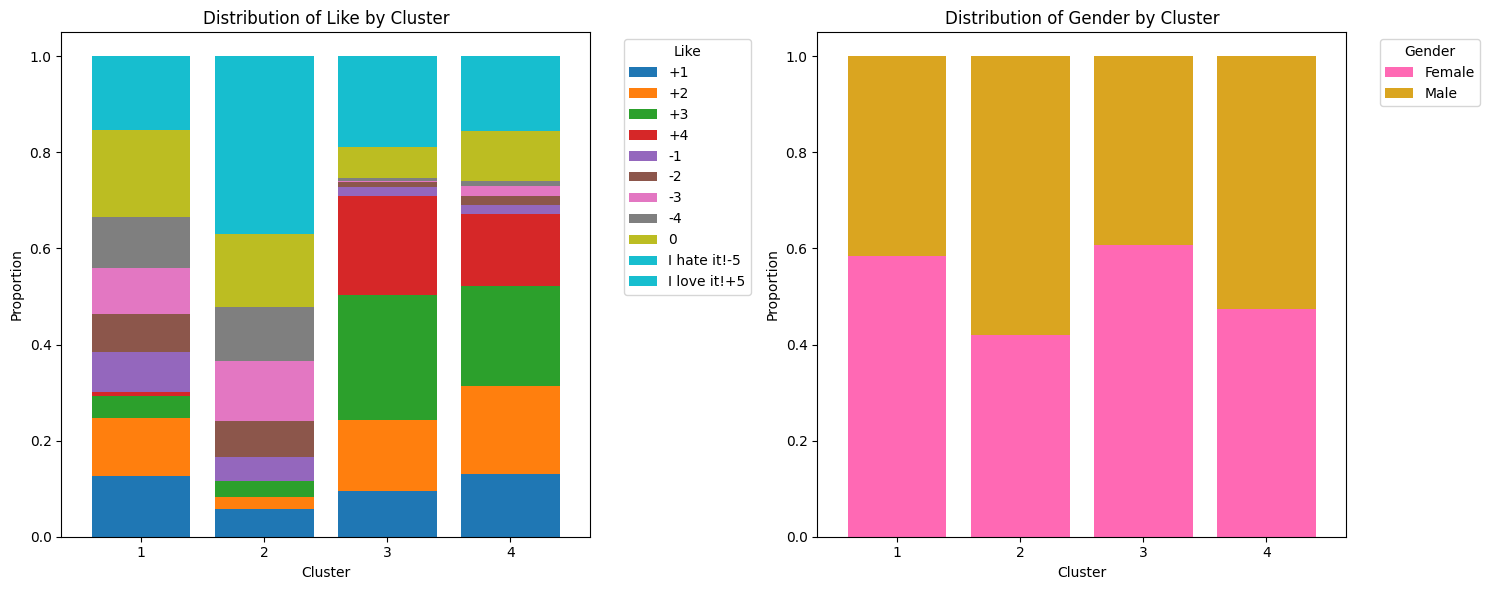

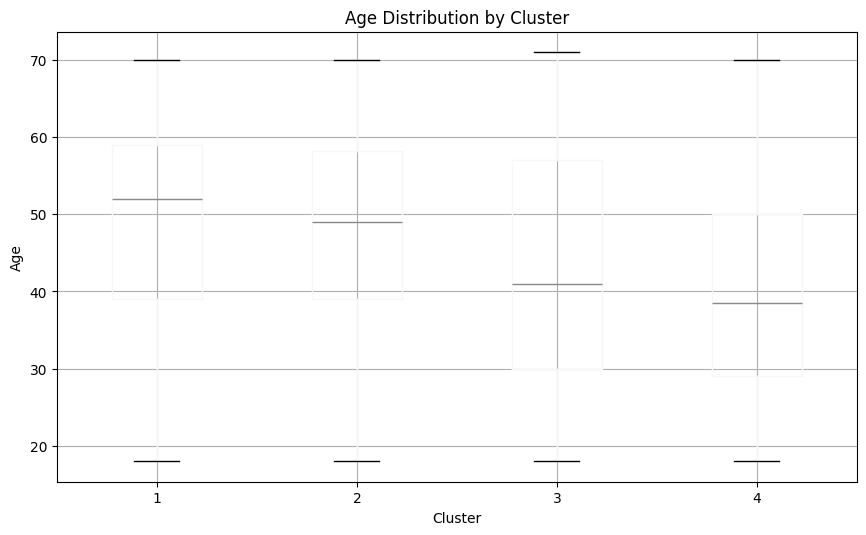

In [ ]:
print("\n=== Step 7: Describing Segments ===")

# Add cluster labels to dataframe (using k4_labels from k-means, not k4_clusters)
mcdonalds['Cluster'] = k4_clusters + 1  # Start from 1 instead of 0

# Analyze relationship between clusters and Like
contingency_like = pd.crosstab(mcdonalds['Cluster'], mcdonalds['Like'])
print("Contingency table: Cluster vs Like")
print(contingency_like)

# Import chi-square test function
from scipy.stats import chi2_contingency

# Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_like)
print(f"\nChi-square test: χ² = {chi2:.3f}, p-value = {p_value:.3f}")

# Create stacked bar plots with better styling
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Like vs Cluster - convert to proportions and plot
contingency_like_pct = contingency_like.div(contingency_like.sum(axis=1), axis=0)
contingency_like_pct.plot(kind='bar', stacked=True, ax=axes[0],
                         colormap='tab10', width=0.8)
axes[0].set_title('Distribution of Like by Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Proportion')
axes[0].legend(title='Like', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Gender vs Cluster - convert to proportions and plot
contingency_gender = pd.crosstab(mcdonalds['Cluster'], mcdonalds['Gender'])
print("\nContingency table: Cluster vs Gender")
print(contingency_gender)

contingency_gender_pct = contingency_gender.div(contingency_gender.sum(axis=1), axis=0)
contingency_gender_pct.plot(kind='bar', stacked=True, ax=axes[1],
                           color=['#ff69b4', '#daa520'], width=0.8)  # Pink for Female, Gold for Male
axes[1].set_title('Distribution of Gender by Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Proportion')
axes[1].legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# Age distribution by cluster
plt.figure(figsize=(10, 6))
mcdonalds.boxplot(column='Age', by='Cluster', ax=plt.gca())
plt.title('Age Distribution by Cluster')
plt.suptitle('')  # Remove automatic title
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.show()

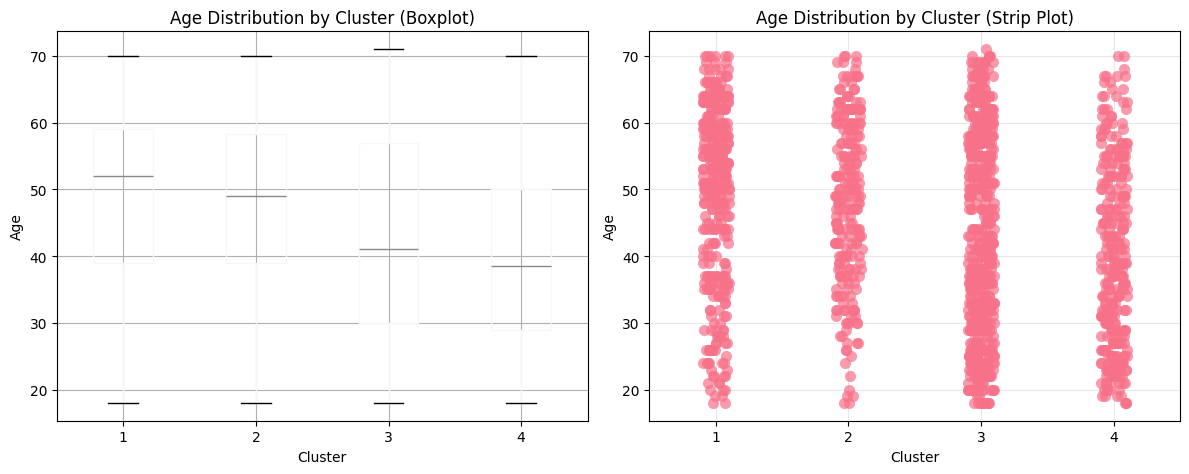

In [ ]:
# Better visualization for small datasets
plt.figure(figsize=(12, 5))

# Subplot 1: Boxplot (current)
plt.subplot(1, 2, 1)
mcdonalds.boxplot(column='Age', by='Cluster', ax=plt.gca())
plt.title('Age Distribution by Cluster (Boxplot)')
plt.suptitle('')
plt.xlabel('Cluster')
plt.ylabel('Age')

# Subplot 2: Strip plot (better for small datasets)
plt.subplot(1, 2, 2)
sns.stripplot(data=mcdonalds, x='Cluster', y='Age', size=8, alpha=0.7)
plt.title('Age Distribution by Cluster (Strip Plot)')
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

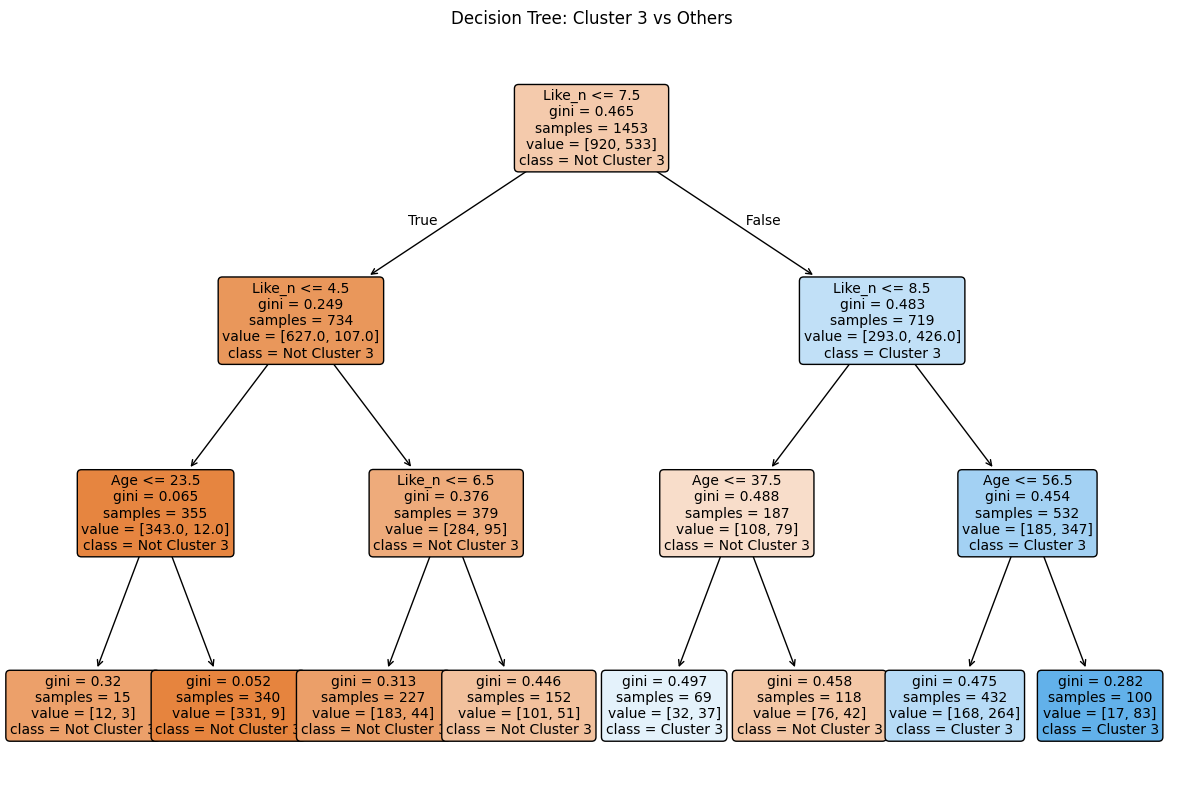

In [ ]:
# Decision tree for cluster 3 vs others
mcdonalds['is_cluster_3'] = (mcdonalds['Cluster'] == 3).astype(int)

# Prepare features for decision tree
tree_features = ['Like_n', 'Age']
# Add visit frequency as numeric
visit_freq_map = {'Never': 0, 'Once a year': 1, 'Every three months': 2,
                  'Once a month': 3, 'Once a week': 4, 'More than once a week': 5}
mcdonalds['VisitFrequency_n'] = mcdonalds['VisitFrequency'].map(visit_freq_map)
tree_features.append('VisitFrequency_n')

# Add gender as binary
mcdonalds['Gender_Female'] = (mcdonalds['Gender'] == 'Female').astype(int)
tree_features.append('Gender_Female')

X_tree = mcdonalds[tree_features]
y_tree = mcdonalds['is_cluster_3']

# Fit decision tree
tree_model = DecisionTreeClassifier(max_depth=3, random_state=1234)
tree_model.fit(X_tree, y_tree)

# Plot decision tree
plt.figure(figsize=(15, 10))
plot_tree(tree_model, feature_names=tree_features, class_names=['Not Cluster 3', 'Cluster 3'],
          filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree: Cluster 3 vs Others')
plt.show()


**STEP 8: Segment Evaluation**

---




=== Step 8: Segment Evaluation ===
Segment characteristics:
         Visit_Frequency_Mean  Like_Mean  Female_Proportion  Cluster_Size
Cluster                                                                  
1                       1.709      4.824              0.585           364
2                       1.408      3.329              0.421           240
3                       3.000      8.835              0.608           533
4                       2.861      8.174              0.475           316


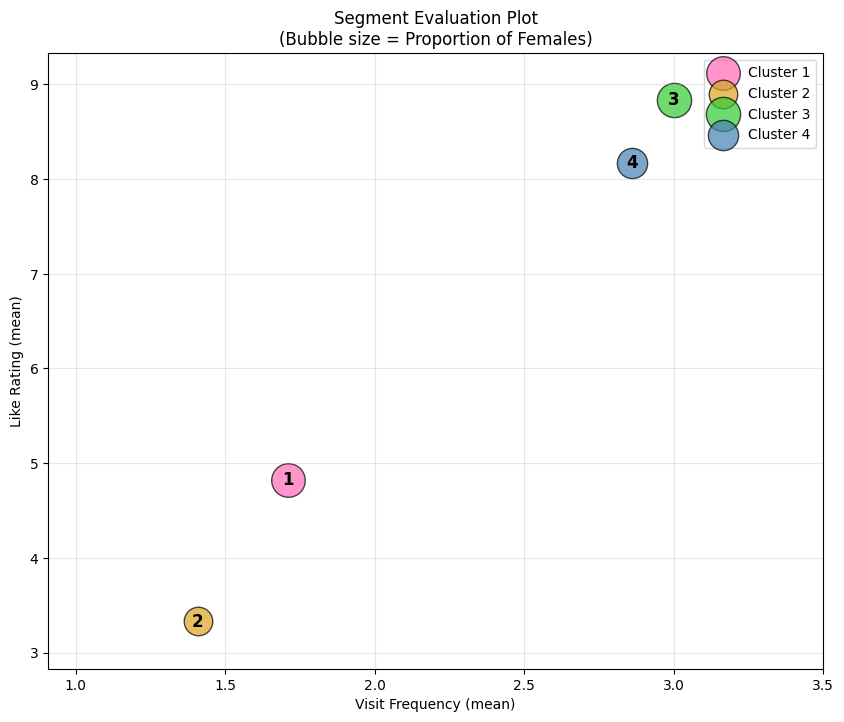


=== Analysis Complete ===
Summary of 4 clusters:

Cluster 1 (n=364):
  Top attributes: fast, fattening, convenient
  Average age: 49.1
  Female proportion: 0.59
  Average like rating: 4.82
  Average visit frequency: 1.71

Cluster 2 (n=240):
  Top attributes: fattening, expensive, fast
  Average age: 48.1
  Female proportion: 0.42
  Average like rating: 3.33
  Average visit frequency: 1.41

Cluster 3 (n=533):
  Top attributes: convenient, tasty, yummy
  Average age: 42.9
  Female proportion: 0.61
  Average like rating: 8.83
  Average visit frequency: 3.00

Cluster 4 (n=316):
  Top attributes: convenient, tasty, expensive
  Average age: 39.7
  Female proportion: 0.47
  Average like rating: 8.17
  Average visit frequency: 2.86


In [ ]:
print("\n=== Step 8: Segment Evaluation ===")

# Calculate segment characteristics
visit_means = mcdonalds.groupby('Cluster')['VisitFrequency_n'].mean()
like_means = mcdonalds.groupby('Cluster')['Like_n'].mean()
female_prop = mcdonalds.groupby('Cluster')['Gender_Female'].mean()  # Changed from 'Gender_n'

print("Segment characteristics:")
summary_df = pd.DataFrame({
    'Visit_Frequency_Mean': visit_means,
    'Like_Mean': like_means,
    'Female_Proportion': female_prop,
    'Cluster_Size': mcdonalds['Cluster'].value_counts().sort_index()
})
print(summary_df.round(3))

# Create evaluation plot with dynamic axis limits
plt.figure(figsize=(10, 8))

# Define colors for each cluster
colors = ['#ff69b4', '#daa520', '#32cd32', '#4682b4']  # Pink, Gold, Green, Blue

for i in range(4):
    cluster_num = i + 1
    plt.scatter(visit_means[cluster_num], like_means[cluster_num],
                s=1000*female_prop[cluster_num], alpha=0.7,
                color=colors[i], edgecolors='black', linewidth=1,
                label=f'Cluster {cluster_num}')
    plt.text(visit_means[cluster_num], like_means[cluster_num],
             str(cluster_num), ha='center', va='center',
             fontweight='bold', fontsize=12)

plt.xlabel('Visit Frequency (mean)')
plt.ylabel('Like Rating (mean)')
plt.title('Segment Evaluation Plot\n(Bubble size = Proportion of Females)')
plt.legend()
plt.grid(True, alpha=0.3)

# Set dynamic axis limits based on actual data
x_min, x_max = visit_means.min() - 0.5, visit_means.max() + 0.5
y_min, y_max = like_means.min() - 0.5, like_means.max() + 0.5
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

print("\n=== Analysis Complete ===")
print("Summary of 4 clusters:")

# First, let's create the profiles_df if it doesn't exist
if 'profiles_df' not in locals():
    profiles_df = pd.DataFrame()
    binary_cols = mcdonalds.columns[:11]  # First 11 columns are binary attributes
    for i in range(4):
        cluster_num = i + 1
        cluster_data = mcdonalds[mcdonalds['Cluster'] == cluster_num]
        profile = cluster_data[binary_cols].mean()
        profiles_df[f'Cluster {cluster_num}'] = profile
    profiles_df = profiles_df.T

for i in range(4):
    cluster_num = i + 1
    cluster_data = mcdonalds[mcdonalds['Cluster'] == cluster_num]

    if len(profiles_df) > 0:
        top_attributes = profiles_df.loc[f'Cluster {cluster_num}'].nlargest(3)
        top_attr_names = ', '.join(top_attributes.index)
    else:
        top_attr_names = "N/A"

    print(f"\nCluster {cluster_num} (n={len(cluster_data)}):")
    print(f"  Top attributes: {top_attr_names}")
    print(f"  Average age: {cluster_data['Age'].mean():.1f}")
    print(f"  Female proportion: {female_prop[cluster_num]:.2f}")
    print(f"  Average like rating: {like_means[cluster_num]:.2f}")
    print(f"  Average visit frequency: {visit_means[cluster_num]:.2f}")